In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data_tomato_price = pd.read_csv("data/data_tomato_price.csv")
data_tomato_price.head(3)

,date,tomato_price
0,2015-01-02,0.62
1,2015-01-09,0.33
2,2015-01-16,0.34


In [3]:
#I modified DataFrame to adapt to Prophet: the prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast
df_prophet = data_tomato_price.rename(columns={'date': 'ds', 'tomato_price': 'y'})
df_prophet.tail(3)

,ds,y
258,2019-12-13,0.43
259,2019-12-20,0.42
260,2019-12-27,0.42


In [7]:
# Development of training function: 
#I looked the outliers dates in exploratory data plot, and in the dataset
#Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument.

def train(df):
    outliers = pd.to_datetime(['2015-01-16', '2015-01-30', '2015-02-13', '2015-02-20', '2015-02-27', '2015-03-04', '2015-03-27', \
        '2016-01-01', '2016-01-15', '2016-01-22', '2016-01-29', '2016-03-25', \
        '2017-03-17', '2017-03-24', '2018-02-02', '2018-02-03', '2018-02-16', '2018-02-23', \
        '2018-03-16', '2018-03-23', '2018-03-30', '2018-09-21', '2018-09-28', \
        '2019-05-04', '2019-05-07', '2019-09-13', '2019-09-20', '2019-12-13', '2019-12-20', '2019-12-27'])
    
    outliers_days = pd.DataFrame({
    'holiday': 'Atypical',
    'ds'     : outliers
    })             
    #Prophet model
    forecast_model = Prophet(growth='linear',  weekly_seasonality=3, yearly_seasonality=3, holidays=outliers_days)
    model = forecast_model.fit(df)
    return model
                   

In [8]:
# Development of prediction function
#ts_test: list of date for four years when I wish the predictions

def predict(model, ts_test):
    
    preds = model.predict(ts_test)
    return preds

In [9]:
model = train(df_prophet)

# I get a suitable dataframe that extends into the future for four years using the helper 
#method Prophet.make_future_dataframe
ts_test = model.make_future_dataframe(periods=1460, include_history=True)
preds = predict(model, ts_test)
preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1716,2023-12-22,0.678293,0.280304,1.074048
1717,2023-12-23,0.516653,0.122882,0.907911
1718,2023-12-24,0.506805,0.080384,0.909063
1719,2023-12-25,0.497026,0.061601,0.894256
1720,2023-12-26,0.487332,0.096773,0.875383


# Interpreting and understanding the model

Text(63.0, 0.5, 'yhat')

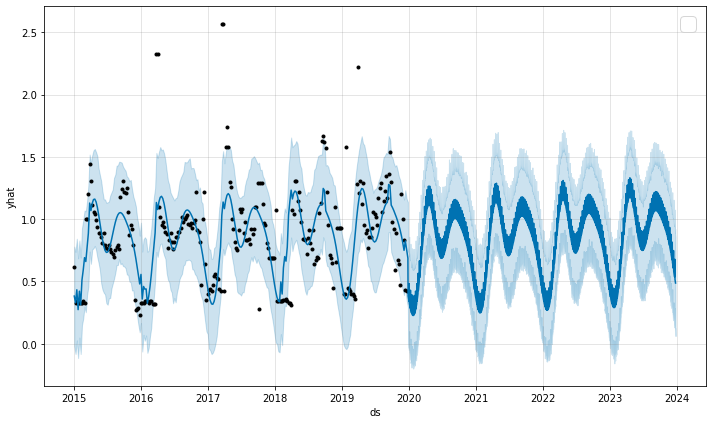

In [10]:
#To see how the model fits existing data and what a forecast over 4 years looks like.

model_predictions = model.predict(ts_test)

plot_pred = model.plot(model_predictions)
plt.legend(loc='best', fontsize=20)
plt.ylabel('yhat')

 In the plot, the black dots correspond to the observed tomato price each week. The dark blue line (labeled 'yhat') corresponds to the estimated tomato price on the estimated model. Finally, the light blue lines correspond to the 80% confidence interval for the models predictions.  

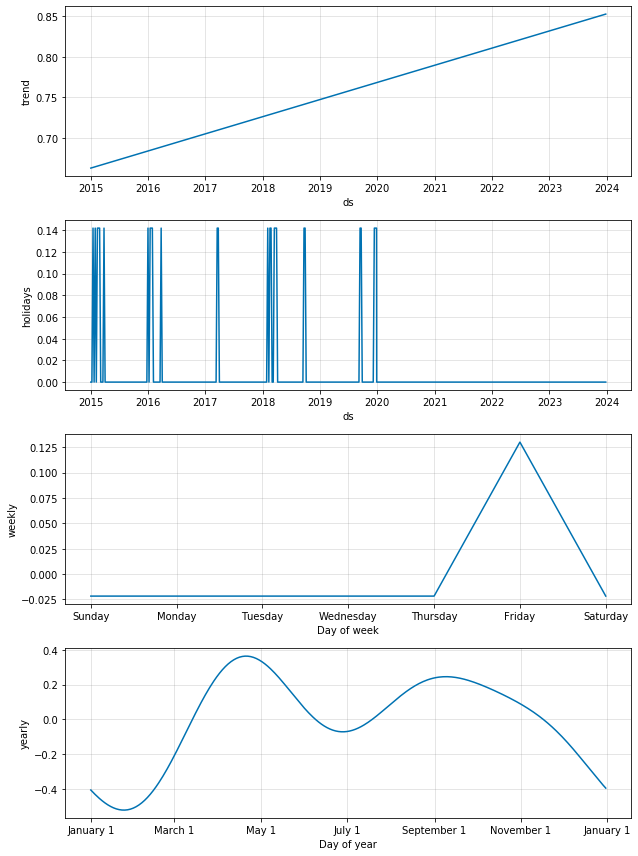

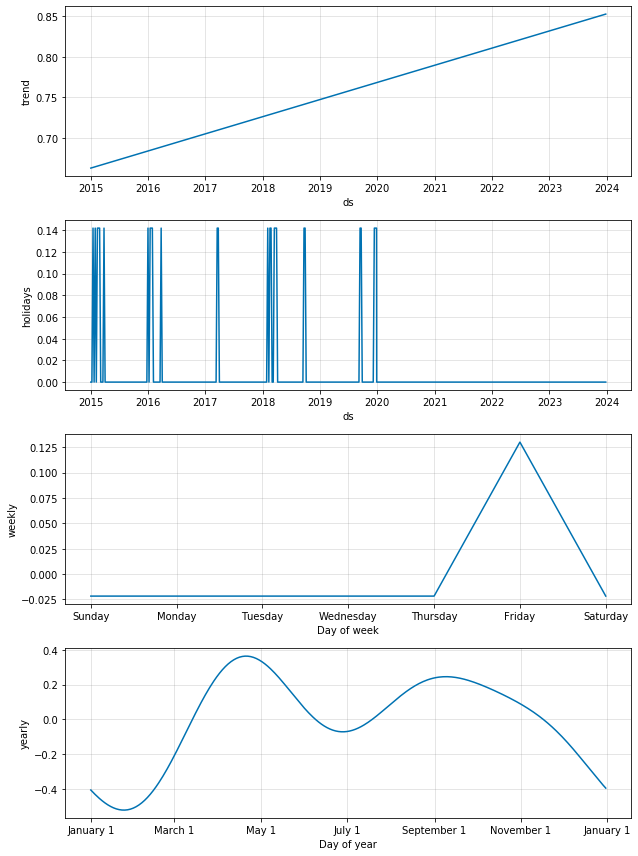

In [11]:
model.plot_components(model_predictions, uncertainty=False)

# Prophet Diagnostics

In [12]:
#Here, Prophet only identified a downward trend with no seasonality.
#Evaluate performance of the model by calculating its mean square  error (MSE) :

#Prophet includes functionality for time series cross validation to measure forecast error using historical data
#This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up 
#to that cutoff point. We can then compare the forecasted values to the actual values.
# y is the true value and yhat forecast value
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='330 days', period='1460 days', horizon = '365 days')



INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-27 00:00:00 and 2018-12-27 00:00:00


In [13]:
#These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). 
#By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,coverage
0,36 days,0.372305,0.610168,0.398601,0.383612,0.6
1,43 days,0.332946,0.577014,0.324975,0.324377,0.8
2,50 days,0.332504,0.576632,0.316257,0.302498,0.8
3,57 days,0.333658,0.577631,0.322115,0.317143,0.8
4,64 days,0.017221,0.131227,0.110756,0.265590,1.0


In [14]:
df_p.mean()

horizon     200 days 12:00:00
mse                  0.114963
rmse                 0.307713
mae                  0.252016
mape                 0.309305
coverage             0.883333
dtype: object

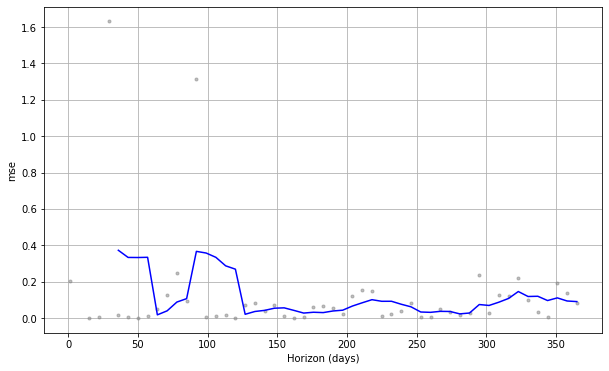

In [15]:
#Cross validation performance metrics
#Here shown for mse. Dots show the mean square error for each prediction. 
#The blue line shows the mse. 

from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mse')

In the figure, the initial period should be long enough to capture all of the components of the model: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

## Comparison of mse without holidays parameters and adding changepoint_prior_scale parameter 


In [16]:
def train_without_holidays(df):             
    #Prophet model
    forecast_model = Prophet(changepoint_prior_scale=0.01, growth='linear',  weekly_seasonality=3, yearly_seasonality=3)
    model = forecast_model.fit(df)
    return model

In [17]:
model_without_holidays = train_without_holidays(df_prophet)
# I get a suitable dataframe that extends into the future for four years 
#using the helper method Prophet.make_future_dataframe
preds_without_holidays = predict(model_without_holidays, ts_test)
preds_without_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1716,2023-12-22,0.571014,0.191017,0.983379
1717,2023-12-23,0.355619,-0.063675,0.756445
1718,2023-12-24,0.346337,-0.071708,0.745512
1719,2023-12-25,0.337131,-0.042777,0.720645
1720,2023-12-26,0.328015,-0.084890,0.738028


Text(63.0, 0.5, 'Tomato price')

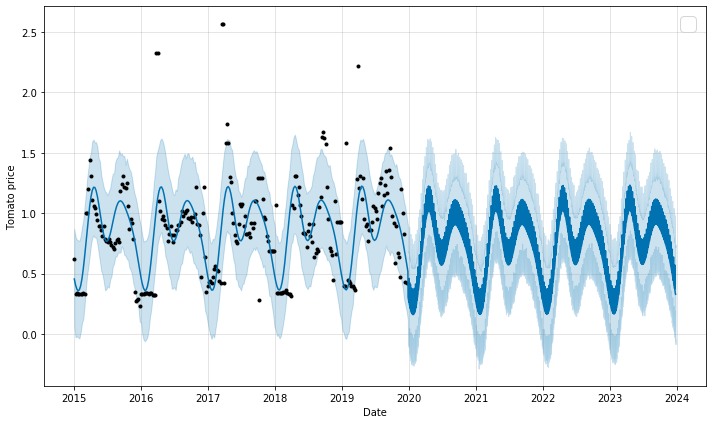

In [18]:
plot_pred = model_without_holidays.plot(preds_without_holidays)
plt.legend(loc='best', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Tomato price')

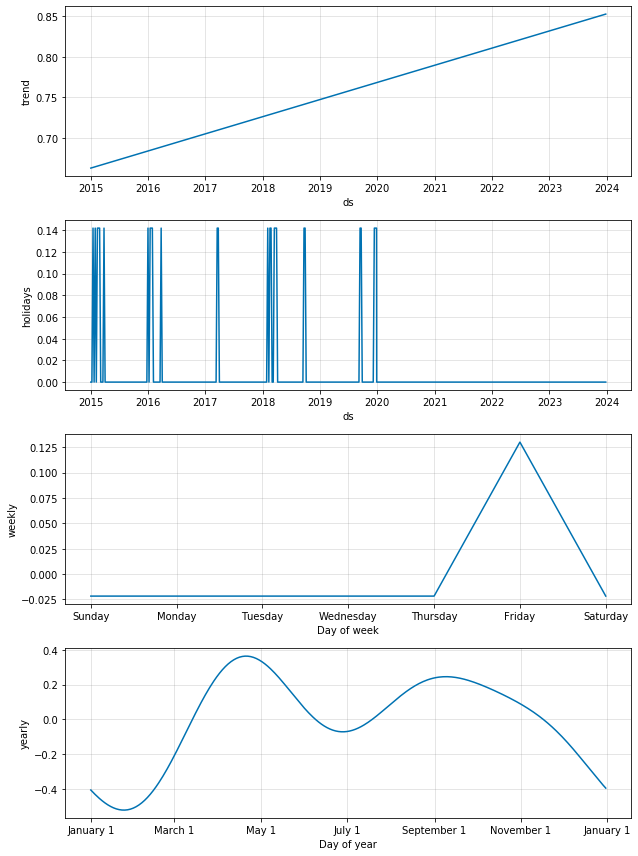

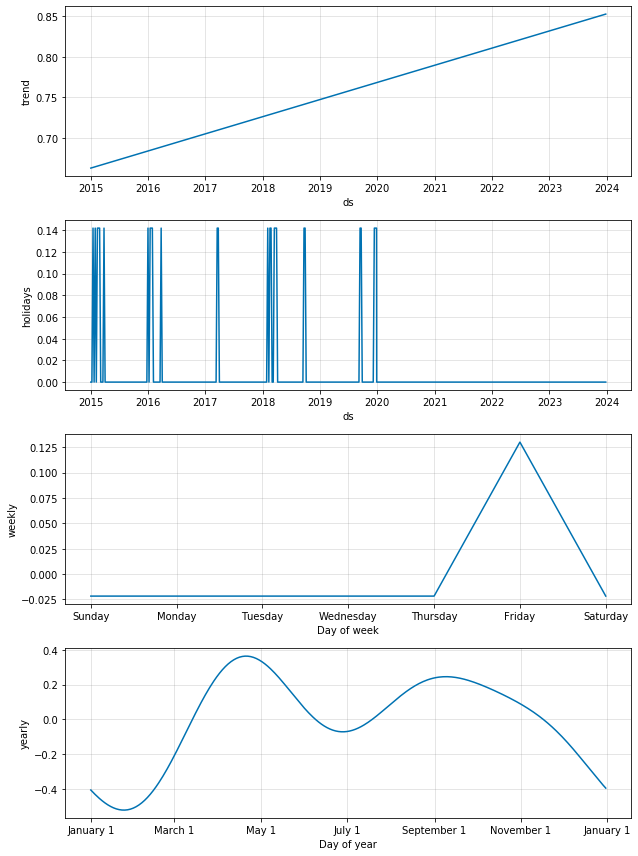

In [19]:
model.plot_components(model_predictions, uncertainty=False)

In [20]:
df_cv_without_holidays = cross_validation(model_without_holidays, initial='730 days', period='1460 days', horizon = '365 days')
df_cv_without_holidays.mean()
from scipy.stats import spearmanr
coef, p = spearmanr(df_cv_without_holidays.y, df_cv_without_holidays.yhat)
coef, p

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-27 00:00:00 and 2018-12-27 00:00:00


(0.5233713237866358, 6.8580667842352e-05)

In [21]:
df_p_without_holidays = performance_metrics(df_cv_without_holidays)
df_p_without_holidays.mean()

horizon     200 days 12:00:00
mse                  0.112645
rmse                 0.310213
mae                  0.253773
mape                 0.326644
coverage                0.875
dtype: object

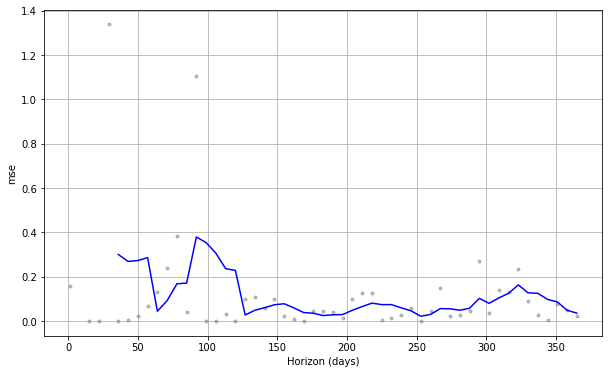

In [22]:
fig = plot_cross_validation_metric(df_cv_without_holidays, metric='mse')

The mean square error is slightly lower without holidays than with holidays selection 

# Comparison of mse with dataset split in train and test

In [23]:
# I split train dataset unti 2019 and test dataset 2019
split_date = '2019-01-04'
df_train = df_prophet.loc[df_prophet.ds < split_date].copy()
df_test = df_prophet.loc[df_prophet.ds > split_date].copy()

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape, 

((209, 2), (51, 2))

In [24]:
model_without_holidays_split = train_without_holidays(df_train)
# I get a suitable dataframe that extends into the future for four years 
#using the helper method Prophet.make_future_dataframe
preds_without_holidays_split = predict(model_without_holidays_split, df_test)
preds_without_holidays_split[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
46,2019-11-29,0.863587,0.426043,1.273095
47,2019-12-06,0.798849,0.399311,1.199834
48,2019-12-13,0.731221,0.364068,1.143963
49,2019-12-20,0.663710,0.243614,1.058643
50,2019-12-27,0.600133,0.163231,1.018319


Text(63.0, 0.5, 'Tomato price')

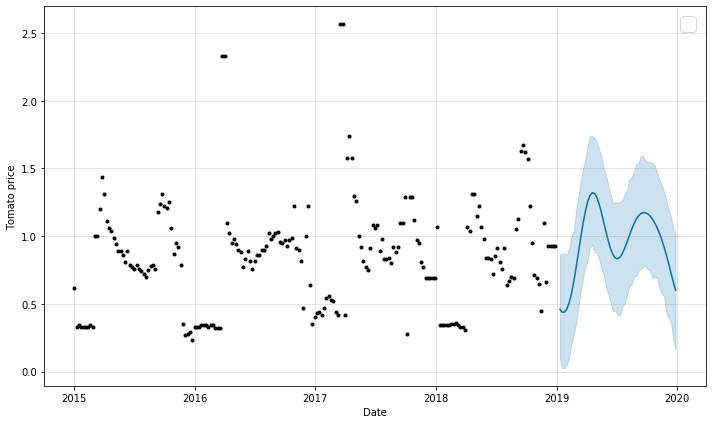

In [25]:
plot_pred = model_without_holidays_split.plot(preds_without_holidays_split)
plt.legend(loc='best', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Tomato price')

In [27]:
df_cv_without_holidays_split = cross_validation(model_without_holidays_split, initial='730 days', period='1460 days', horizon = '365 days')
df_cv_without_holidays_split.mean()
from scipy.stats import spearmanr
coef, p = spearmanr(df_cv_without_holidays_split.y, df_cv_without_holidays_split.yhat)
coef, p

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-12-28 00:00:00 and 2017-12-28 00:00:00


(0.40121927977501265, 0.002906379764772238)

In [28]:
df_p_without_holidays_split = performance_metrics(df_cv_without_holidays_split)
df_p_without_holidays_split.mean()

horizon     197 days 00:00:00
mse                  0.144925
rmse                 0.321799
mae                  0.280787
mape                 0.517913
coverage             0.673469
dtype: object

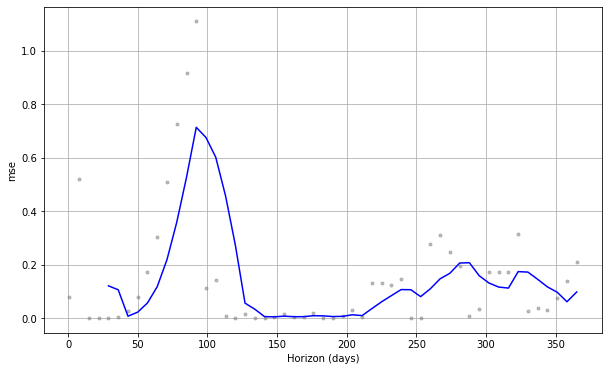

In [29]:
fig = plot_cross_validation_metric(df_cv_without_holidays_split, metric='mse')